# Part V: Producing a distributed dataset

Authors: Jordi Bolibar & Facundo Sapienza

```{note}
Before running this notebook, be sure you Jupyter kernel (top left corner of the notebook) has been configure to work with the MB_Finsen conda environment. 
```

## 5.1. Context

As you might have realized, the glacier-wide geodetic mass balance data used in the previous notebooks is extremely noisy. Moreover, the scientific interest of such dataset is limited in terms of prediction, since we deliberately used a simple dataset to explain the basic machine learning workflow. Generally, remote sensing datasets have a very good spatial coverage, but low temporal resolution. The actual dataset from [Hugonnet et al. (2021)](https://www.nature.com/articles/s41586-021-03436-z) consist on raster grids with the distributed geodetic mass balance of each glacier in the world for multiple periods. This means that we have additional spatial mass balance information than just a single glacier-wide value. Exploiting such data can be very interesting, due to the increased richness of information. 

Alternatively, the [OGGM Shop](https://docs.oggm.org/en/stable/shop.html) also provides access to a wide range of datasets of glaciers, which can be used for training machine learning models. As we will shown in this notebook, with just a few lines of code we can get all the necessary data for a region of interest in order to start training machine learning models. 

Here, we propose two different more advanced projects to exploit spatially distributed (i.e. gridded) raster data. These projects can be tackled with the previous methods seen in Notebook 3, or for the boldest ones, you can try to use convolutional neural networks in order to extract spatial information present in the gridded data. These notebooks will draw heavily from the awesome resources provided by OGGM, particularly from [this machine learning-oriented notebook](https://oggm.org/tutorials/stable/notebooks/10minutes/machine_learning.html), and [this new tutorial on retrieving state-of-the-art datasets](https://oggm.org/training-lahore/day_4/01_data_prep.html).

```{note}
In this notebook, we will adapt Notebook 1 in order to produce a similar dataset but in a distributed fashion, i.e. in 2D, so we can model each grid cell of the glacier instead of using glacier-wide information. 
```

## 5.2. Re-computing a distributed dataset

In [1]:
import oggm
oggm.__version__

'1.5.4.dev44+ga032552'

We import all the necessary dependencies to retrieve the data with OGGM and to postprocess it. We use multiprocessing with OGGM to make things faster.

In [2]:
import xarray as xr
import numpy as np
import rioxarray
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm import entity_task, global_tasks
from oggm.utils import compile_climate_input
from oggm.core import gis
from oggm.utils import DEM_SOURCES
from pathlib import Path
import os
import logging
from datetime import datetime, timedelta

pd.set_option('display.max_columns',None)

cfg.initialize(logging_level='WARNING')
cfg.PARAMS['border'] = 10
cfg.PARAMS['use_multiprocessing'] = True 
cfg.PARAMS['continue_on_error'] = True
# Module logger
log = logging.getLogger('.'.join(__name__.split('.')[:-1]))

2023-04-19 09:27:02: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-04-19 09:27:02: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-04-19 09:27:02: oggm.cfg: Multiprocessing: using all available processors (N=16)
2023-04-19 09:27:02: oggm.cfg: PARAMS['border'] changed from `40` to `10`.
2023-04-19 09:27:02: oggm.cfg: Multiprocessing switched ON after user settings.
2023-04-19 09:27:02: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


Choose your OGGM path where you want to store all the data. Since we are all working in the same Hub, we can store the information in the same shared folder. Here we use a different folder than in notebook 1, specifying that it deals with distributed data. 

In [3]:
parent_path = os.path.dirname(Path().resolve())
workspace_path = os.path.join(parent_path, 'OGGM_data_Finse_distributed')
#workspace_path = '/home/jovyan/shared/glacier-ml-2022/Mass_Balance_ML_Modelling/Data'

if not os.path.exists(workspace_path):
    os.mkdir(workspace_path)

cfg.PATHS['working_dir'] = workspace_path

As it was done in notebook 1, here we create a new entity task in order to produce the distributed dataset. Both the distributed data and the climate data are available for each glacier directory as netCDF files, which we will read and process using `xarray`.

We re-introduce the helper function in order to convert `datetimes` to the right format.

In [4]:
def decimal_to_datetime(ds):
    datetimes = []
    for dec_year in ds.time.data:
        year = int(dec_year)
        rem = dec_year - year

        base = datetime(year, 1, 1)
        calendar_time = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
        datetimes.append(calendar_time)
        
    climate_ds['time'] = datetimes
        
    return climate_ds

And now we declare the actual entity task.

In [5]:
@entity_task(log)
def get_gridded_features(gdir):
    """Retrieves and processes gridded and climate data for a gdir in order to create the dataset
        to be fed to machine learning models.
    """
    # Retrieve gridded data
    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        gridded_ds = ds.load()
    # Retrieve climate data
    with xr.open_dataset(gdir.get_filepath('climate_historical')) as ds:
        climate_ds = ds.load()
    
    #### Climate data ####
    # First we start by processing the climate data
    # Trim climate dataset to desired period of the Hugonnet et al. (2021) dataset
    climate_ds = climate_ds.sel(time=slice('2000-01-01','2019-12-01')) 
    
    # Now we downscale the climate data to the specific glacier 
    # Temperature
    temps_2D = np.empty((climate_ds.temp.data.size, gridded_ds.topo.data.shape[0], gridded_ds.topo.data.shape[1]))
    i = 0
    for temp in climate_ds.temp.data:
        temps_2D[i,:,:] = np.tile(temp,gridded_ds.topo.data.shape) + 6.0/1000.0*(gridded_ds.topo.data - climate_ds.ref_hgt.data)
        i=i+1
    
    PDD_2D = np.sum(np.where(temps_2D > 0.0, temps_2D, 0.0), axis=0)
    
    # Rain
    rain_period_2D = np.empty((climate_ds.prcp.data.size, gridded_ds.topo.data.shape[0], gridded_ds.topo.data.shape[1]))
    i = 0
    for prcp in climate_ds.prcp.data:
        rain_period_2D[i,:,:] = np.tile(prcp,gridded_ds.topo.data.shape) 
        i=i+1
    
    rain_2D = np.sum(rain_period_2D, axis=0)
    
    # Snow
    snow_2D = np.sum(np.where(temps_2D < 0.0, rain_period_2D, 0.0), axis=0)
        
    # Now we create a dictionary with the full dataset, including the previous climate data
    # and all the interesting gridded datasets 
    training_data = {'PDD_2D': PDD_2D,
                 'rain_2D': rain_2D,
                 'snow_2D': snow_2D,
                 'topo': gridded_ds.topo.data,
                 'aspect': gridded_ds.aspect.data,
                 'slope': gridded_ds.slope.data,
                 'dis_from_border': gridded_ds.dis_from_border.data,
                 'glacier_mask': gridded_ds.glacier_mask.data,
                 'millan_ice_thickness': np.nan_to_num(gridded_ds.millan_ice_thickness.data),
                 'hugonnet_dhdt': np.nan_to_num(gridded_ds.hugonnet_dhdt.data),
                 'ID': gdir.rgi_id
        }
    
    return training_data

Download all data from glaciers in Scandinavia (RGI region '08'). We use a specific directory with preprocessed data, including all the nice distributed datasets that we need. 

In [6]:
rgi_region = '08' # Scandinavia
rgi_version = '6'
rgi_dir = utils.get_rgi_dir(version=rgi_version)
path = utils.get_rgi_region_file(region=rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)
# We use the directories with the shop data in it: "W5E5_w_data"
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/'
gdirs = workflow.init_glacier_directories(rgidf, from_prepro_level=3, prepro_base_url=base_url, prepro_border=10)

2023-04-19 09:27:04: oggm.workflow: init_glacier_directories from prepro level 3 on 3417 glaciers.
2023-04-19 09:27:04: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 3417 glaciers
2023-04-19 09:30:08: root: AttributeError occurred during task get_gridded_features on RGI60-08.00004: 'Dataset' object has no attribute 'topo'
2023-04-19 09:30:08: root: AttributeError occurred during task get_gridded_features on RGI60-08.00001: 'Dataset' object has no attribute 'topo'
2023-04-19 09:30:08: root: AttributeError occurred during task get_gridded_features on RGI60-08.00002: 'Dataset' object has no attribute 'topo'
2023-04-19 09:30:08: root: AttributeError occurred during task get_gridded_features on RGI60-08.00003: 'Dataset' object has no attribute 'topo'
2023-04-19 09:30:12: root: AttributeError occurred during task get_gridded_features on RGI60-08.00263: 'Dataset' object has no attribute 'millan_ice_thickness'
2023-04-19 09:30:12: root: AttributeError occurred during task get_gridd

Let's add some additional data to all that.

In [7]:
# Tested tasks
task_list = [
    tasks.gridded_attributes,
    tasks.gridded_mb_attributes,
]
for task in task_list:
    workflow.execute_entity_task(task, gdirs, print_log=False)

2023-04-19 09:28:37: oggm.workflow: Execute entity tasks [gridded_attributes] on 3417 glaciers
2023-04-19 09:29:41: oggm.workflow: Execute entity tasks [gridded_mb_attributes] on 3417 glaciers


## 5.3. Exploring the dataset

In order to get a rough idea on how the data looks like, let's take a quick look at the gridded data we added to our dataset. We'll use the netCDF file read with `xarray`. This is different to the dataset we have created, since for that we just kept raw data as matrices, which is what is needed for the machine learning models. Let's take a look at the famous Nigardsbreen.

In [8]:
for gdir in gdirs:
    if (gdir.name == 'Nigardsbreen'):
        break

In [9]:
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()
# List all variables
ds

<xarray.Dataset>
Dimensions:                  (x: 108, y: 108)
Coordinates:
  * x                        (x) float32 -4.117e+03 -4.016e+03 ... 6.69e+03
  * y                        (y) float32 6.848e+06 6.848e+06 ... 6.837e+06
Data variables: (12/17)
    topo                     (y, x) float32 545.2 473.4 365.1 ... 716.0 623.4
    topo_smoothed            (y, x) float32 585.5 530.5 436.3 ... 667.4 612.1
    topo_valid_mask          (y, x) int8 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    glacier_mask             (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    glacier_ext              (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    consensus_ice_thickness  (y, x) float32 nan nan nan nan ... nan nan nan nan
    ...                       ...
    glacier_ext_erosion      (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    ice_divides              (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    slope                    (y, x) float32 0.8242 0.8921 ... 0.7463 0.7007
    aspect                   (y, x) float32 0.528 0.638 0.7656 ... 0.7515 0.706
    slope_factor             (y, x) float32 1.123 1.071 1.016 ... 1.192 1.238
    dis_from_border          (y, x) float32 9.213e+03 9.143e+03 ... 1.428e+03
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=7.099 +k=0.9996 +x_0=0 +y_0=0...
    max_h_dem:      1970.0707
    min_h_dem:      88.412544
    max_h_glacier:  1939.6395
    min_h_glacier:  311.37354

We can see there's a huge amount of data available here. Since we interested in modelling distributed mass balance, we'll take a look at the `hugonnet_dhdt` data.

First we prepare the map to start plotting the datasets.

In [10]:
smap = ds.salem.get_map(countries=False)
smap.set_shapefile(gdir.read_shapefile('outlines'))
smap.set_topography(ds.topo.data);

And now we plot the Hugonnet et al. (2021) geodetic mass balance data for this glacier:

/home/jovyan/.conda/envs/oggm_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/jovyan/.conda/envs/oggm_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


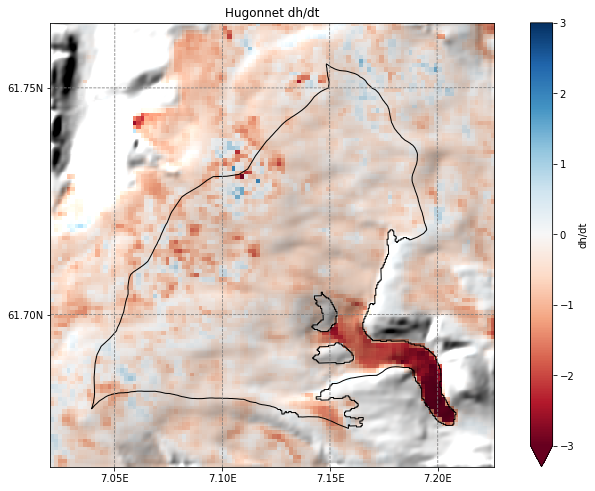

In [11]:
# get the axes ready
f, ax = plt.subplots(figsize=(9, 9))

smap.set_data(ds.hugonnet_dhdt)
smap.set_cmap('RdBu')
smap.set_plot_params(vmin=-3, vmax=3)
smap.plot(ax=ax)
smap.append_colorbar(ax=ax, label='dh/dt')

ax.set_title('Hugonnet dh/dt');

## 5.4. Creating the ML dataset

We now can use the previously declared entity task to create the training dataset using all gridded data of interest for all glaciers in Scandinavia. 

In [12]:
training_data = workflow.execute_entity_task(get_gridded_features, gdirs)

2023-04-19 09:30:08: oggm.workflow: Execute entity tasks [get_gridded_features] on 3417 glaciers


Since there are a few glaciers without the required data, we need to delete some `None` values.

In [13]:
training_dict = np.delete(training_data, np.where(np.array(training_data) == None))

And then we convert the numpy array to a Python list, which then can be turned into a pandas `DataFrame`. This `DataFrame` contains all the matrices with the training data.

In [14]:
df_training = pd.DataFrame.from_dict(training_dict.tolist())

In order to polish it up, we set the RGI ID as the index.

In [15]:
df_training.index = df_training.ID
df_training.index.name = 'RGI_ID'
df_training = df_training.drop(columns='ID')
df_training.head(3)

,PDD_2D,rain_2D,snow_2D,topo,aspect,slope,dis_from_border,glacier_mask,millan_ice_thickness,hugonnet_dhdt
RGI_ID,,,,,,,,,,
RGI60-08.00005,"[[609.424791097641, 615.5821454524994, 626.451...","[[24237.96413451433, 24237.96413451433, 24237....","[[16140.702604591846, 16140.702604591846, 1604...","[[1024.779, 1034.9397, 1052.835, 1063.4498, 10...","[[5.3310027, 5.0751057, 4.781625, 4.4907694, 4...","[[0.10280657, 0.11244187, 0.12546569, 0.125620...","[[1997.029, 1955.7607, 1916.5398, 1879.4946, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.04746728, 0.0915811, 0.083521135, 0.034988..."
RGI60-08.00006,"[[826.7886772155762, 822.2428703308105, 817.85...","[[21702.43186724186, 21702.43186724186, 21702....","[[12161.882670998573, 12161.882670998573, 1216...","[[1518.6793, 1511.7917, 1505.1444, 1498.3704, ...","[[2.1975436, 2.0144162, 1.8260304, 1.7194147, ...","[[0.11423529, 0.15551111, 0.25394234, 0.380362...","[[1082.431, 1066.0, 1050.9125, 1037.227, 1025....","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[nan, nan, nan, nan, nan, nan, 1.3812042, 13....","[[-0.01883984, 0.018018564, 0.05489535, 0.0491..."
RGI60-08.00007,"[[726.1920185089111, 719.3569054603577, 712.02...","[[21702.43186724186, 21702.43186724186, 21702....","[[12885.860416054726, 12914.241635918617, 1291...","[[1363.2493, 1352.2467, 1340.3749, 1328.4084, ...","[[2.1547537, 1.9988006, 1.8559904, 1.7981223, ...","[[0.21319097, 0.27644932, 0.38732976, 0.456547...","[[244.18231, 233.34525, 222.99103, 212.13203, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[-0.028017059, -0.025192646, -0.022339843, -0..."


In [16]:
df_training.iloc[0].topo.shape, df_training.iloc[0].snow_2D.shape,

((111, 114), (111, 114))

In [17]:
df_training.topo.shape

(3340,)

## 5.5. Ravel version of the dataset

In [21]:
def pd_ravel(row, key):
    res = row[key].ravel()
    return pd.DataFrame({key: res})

In [24]:
dict_training = {}

for i in range(df_training.shape[0]):
    df_rgi = df_training.iloc[i]
    n_tot = df_rgi.PDD_2D.size
    #print(n_tot)
    dict_rgi = {'RGI_ID': np.repeat(df_rgi.name, n_tot)}
    for key in df_training.columns:
        dict_rgi[key] = df_rgi[key].ravel()
        #print(key, df_rgi[key].ravel().size)
    df_rgi = pd.DataFrame(dict_rgi)
    dict_training = 

In [25]:
df_rgi

,RGI_ID,PDD_2D,rain_2D,snow_2D,topo,aspect,slope,dis_from_border,glacier_mask,millan_ice_thickness,hugonnet_dhdt
0,RGI60-08.03417,1296.874012,24813.493456,11674.948875,1352.688232,3.325776,0.100528,283.019440,0,NaN,-0.053302
1,RGI60-08.03417,1299.456306,24813.493456,11674.948875,1355.538452,3.372588,0.099746,275.363403,0,NaN,-0.051592
2,RGI60-08.03417,1301.842864,24813.493456,11674.948875,1358.172607,3.386306,0.096438,268.328156,0,NaN,-0.049886
3,RGI60-08.03417,1303.385187,24813.493456,11674.948875,1359.875000,3.205338,0.088175,261.963745,0,NaN,-0.048184
4,RGI60-08.03417,1303.434872,24813.493456,11674.948875,1359.929810,2.762301,0.086262,255.000000,0,NaN,-0.042872
...,...,...,...,...,...,...,...,...,...,...,...
4555,RGI60-08.03417,983.681671,24813.493456,13711.336557,982.789978,2.360861,0.180806,295.846252,0,NaN,-0.006399
4556,RGI60-08.03417,982.406428,24813.493456,13711.336557,981.142395,2.441810,0.168280,308.868896,0,NaN,-0.006643
4557,RGI60-08.03417,981.260829,24813.493456,13711.336557,979.662292,2.566021,0.153481,322.063660,0,NaN,-0.006886
4558,RGI60-08.03417,980.225798,24813.493456,13711.336557,978.325012,2.750872,0.139129,335.410187,0,NaN,-0.007129


Finally, in order to avoid having to run these computationally expensive tasks every time, we save the `DataFrame` on disk to use it later on.

In [20]:
training_df.to_csv('Data/distributed_training_df.csv')

NameError: name 'training_df' is not defined

In [26]:
gdir = gdirs[0]

In [27]:
    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        gridded_ds = ds.load()